In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

In [4]:
root_dir = "/content/drive/My Drive/Colab Notebooks/BiodivBERT-NER/"

root_data_dir = os.path.join(root_dir, "datasets", "Species800")

dataset = "train"
train_csv_file_path = "train.tsv"
val_csv_file_path = "dev.tsv"
test_csv_file_path = "test.tsv"

offline_model_file = os.path.join(root_dir, "BiLSTM-Species800-model")
training_history_csv = "training_Species800_history.csv"

##Util

In [5]:
def load_model():
    json_file = open(offline_model_file+".json", 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    new_model = model_from_json(loaded_model_json)
    # load weights into new model
    new_model.load_weights(offline_model_file+".h5")
    print("Loaded model from disk")
    return new_model

In [6]:
def save_model(model):
    # serialize model to JSON
    model_json = model.to_json()
    
    with open(offline_model_file+".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(offline_model_file+".h5")
    print("Saved model to disk")

In [7]:
def saveDataFrameToCSV(pd1, csv_path, append):  
  dataset_path = os.path.join(root_dir, csv_path)  
  
  if append:
    with open(dataset_path, 'a+') as f:    
      pd1.to_csv(dataset_path,  mode='a', index=False, header=False)    
  else:
    with open(dataset_path, 'a+') as f:    
      pd1.to_csv(dataset_path,  mode='a', index=False, header=True)

##Dataset Preprocessing


In [8]:
import os
import pandas as pd
import numpy as np

In [9]:
def loadData(csv_file_path):
  dataset_path = os.path.join(root_data_dir, csv_file_path)
  data = pd.read_csv(dataset_path, encoding="utf8", sep=',')
  data = data.fillna(method="ffill")
  return data

In [10]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),                                                          
                                                        s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [11]:
data = loadData(train_csv_file_path)

In [12]:
data.head(10)

,Sentence #,Word,Tag
0,Sentence: 1,Methanoregula,B
1,Sentence: 1,formicica,I
2,Sentence: 1,sp,O
3,Sentence: 1,.,O
4,Sentence: 1,nov,O
5,Sentence: 1,.,O
6,Sentence: 1,",",O
7,Sentence: 1,a,O
8,Sentence: 1,methane,O
9,Sentence: 1,-,O


In [13]:
val_data = loadData(val_csv_file_path)

In [14]:
val_data.head(10)

,Sentence #,Word,Tag
0,Sentence: 1,Methanoregula,B
1,Sentence: 1,formicica,I
2,Sentence: 1,sp,O
3,Sentence: 1,.,O
4,Sentence: 1,nov,O
5,Sentence: 1,.,O
6,Sentence: 1,",",O
7,Sentence: 1,a,O
8,Sentence: 1,methane,O
9,Sentence: 1,-,O


In [15]:
test_data =  loadData(test_csv_file_path)

In [16]:
test_data.head(10)

,Sentence #,Word,Tag
0,Sentence: 1,Streptococcus,B
1,Sentence: 1,ursoris,I
2,Sentence: 1,sp,I
3,Sentence: 1,.,I
4,Sentence: 1,nov,I
5,Sentence: 1,.,I
6,Sentence: 1,",",O
7,Sentence: 1,isolated,O
8,Sentence: 1,from,O
9,Sentence: 1,the,O


In [17]:
#if the data are in string style, we propably use tokenzer.fit_on_texts instead of list manipulation like here

VOCAB = list(set(list(data["Word"].values) +                  
                 list(test_data["Word"].values)))
VOCAB.append("ENDPAD")

n_words = len(VOCAB) #n_words includes all vocab from train and validation test.

tags = list(set(data["Tag"].values))

n_tags = len(tags)

In [18]:
print(n_words, VOCAB[0:10] ,VOCAB[n_words-1], sep='\n')

16522
['folds', 'unbiased', 'linkers', 'colocalize', 'behavioural', 'diagnostics', 'symmetric', 'lag', 'DCR2', 'Flexirubin']
ENDPAD


In [19]:
print(n_tags, tags, sep='\n')

3
['I', 'O', 'B']


###Sentences 

In [20]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [21]:
getter_test = SentenceGetter(test_data)
sentences_test = getter_test.sentences

####Exploration

In [22]:
sent = getter_test.get_next()
print(sent)

[('Streptococcus', 'B'), ('ursoris', 'I'), ('sp', 'I'), ('.', 'I'), ('nov', 'I'), ('.', 'I'), (',', 'O'), ('isolated', 'O'), ('from', 'O'), ('the', 'O'), ('oral', 'O'), ('cavities', 'O'), ('of', 'O'), ('bears', 'O'), ('.', 'O'), ('.', 'O')]


In [23]:
sentences[1]

[('The', 'O'),
 ('closest', 'O'),
 ('relative', 'O'),
 ('based', 'O'),
 ('on', 'O'),
 ('both', 'O'),
 ('16S', 'O'),
 ('rRNA', 'O'),
 ('and', 'O'),
 ('mcrA', 'O'),
 ('gene', 'O'),
 ('sequences', 'O'),
 ('was', 'O'),
 ('Methanoregula', 'B'),
 ('boonei', 'I'),
 ('6A8', 'I'),
 ('(', 'O'),
 ('T', 'O'),
 (')', 'O'),
 ('(', 'O'),
 ('96', 'O'),
 ('.', 'O'),
 ('3', 'O'),
 ('%', 'O'),
 ('16S', 'O'),
 ('rRNA', 'O'),
 ('gene', 'O'),
 ('sequence', 'O'),
 ('similarity', 'O'),
 (',', 'O'),
 ('85', 'O'),
 ('.', 'O'),
 ('4', 'O'),
 ('%', 'O'),
 ('deduced', 'O'),
 ('McrA', 'O'),
 ('amino', 'O'),
 ('acid', 'O'),
 ('sequence', 'O'),
 ('similarity', 'O'),
 (')', 'O'),
 ('.', 'O'),
 ('.', 'O')]

In [24]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")

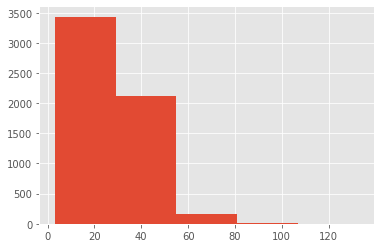

In [25]:
plt.hist([len(s) for s in sentences], bins=5)
plt.show()

In [26]:
max([len(s) for s in sentences])

133

In [27]:
max_len = 93 #selected value outisde the histogram

###Utils

In [28]:
word2idx = {w: i + 1 for i, w in enumerate(VOCAB)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [29]:
word2idx["ENDPAD"]

16522

In [30]:
tag2idx["B"]

2

In [31]:
idx2tag = {i: w for w, i in tag2idx.items()}
index2word = {i: w for w, i in word2idx.items()}

###X & Y Prep

In [32]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

def getXYFromSentences(sentences):
  
  X = [[word2idx[w[0]] for w in s] for s in sentences]
  X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=word2idx["ENDPAD"])
   
  y = [[tag2idx[w[1]] for w in s] for s in sentences]
  y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])
  y = np.array([to_categorical(i, num_classes=n_tags) for i in y])
  return X, y

Using TensorFlow backend.


In [33]:
X_train, y_train = getXYFromSentences(sentences)

In [34]:
X_test, y_test = getXYFromSentences(sentences_test)

#### Exploration

In [35]:
target = X_test[1]

In [36]:
target

array([  370,  8015,  8015, 16522, 16522, 16522, 16522, 16522, 16522,
       16522, 16522, 16522, 16522, 16522, 16522, 16522, 16522, 16522,
       16522, 16522, 16522, 16522, 16522, 16522, 16522, 16522, 16522,
       16522, 16522, 16522, 16522, 16522, 16522, 16522, 16522, 16522,
       16522, 16522, 16522, 16522, 16522, 16522, 16522, 16522, 16522,
       16522, 16522, 16522, 16522, 16522, 16522, 16522, 16522, 16522,
       16522, 16522, 16522, 16522, 16522, 16522, 16522, 16522, 16522,
       16522, 16522, 16522, 16522, 16522, 16522, 16522, 16522, 16522,
       16522, 16522, 16522, 16522, 16522, 16522, 16522, 16522, 16522,
       16522, 16522, 16522, 16522, 16522, 16522, 16522, 16522, 16522,
       16522, 16522, 16522], dtype=int32)

In [37]:
np.asarray([index2word[i] for i in  target])

array(['2006', '.', '.', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD',
       'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD',
       'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD',
       'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD',
       'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD',
       'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD',
       'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD',
       'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD',
       'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD',
       'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD',
       'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD',
       'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD',
       'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD',
       'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD',
       'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD

In [38]:
target = y_train[1]

In [39]:
target.shape


(93, 3)

In [40]:
np.asarray([idx2tag[np.argmax(i)] for i in  target])

array(['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
       'B', 'I', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
       'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
       'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
       'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
       'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
       'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
       'O', 'O'], dtype='<U1')

##Setup the LSTM

In [41]:
from keras import callbacks
from keras.models import Model, Input, model_from_json
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras.optimizers import RMSprop

In [42]:
def create_model():
  input = Input(shape=(max_len,))
  #in the line below --> laurance set the input_length = max_len-1 (NLP in TF Week4)
  model = Embedding(input_dim=n_words, output_dim=50, input_length=max_len)(input)
  model = Dropout(rate=0.1)(model)
  model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
  out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)  # softmax output layer
  
  return Model(input, out)

In [43]:
model = create_model()
#model = load_model()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [44]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 93)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 93, 50)            826100    
_________________________________________________________________
dropout_1 (Dropout)          (None, 93, 50)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 93, 200)           120800    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 93, 3)             603       
Total params: 947,503
Trainable params: 947,503
Non-trainable params: 0
_________________________________________________________________


In [45]:
model.compile(optimizer=RMSprop(), loss="categorical_crossentropy", metrics=["accuracy"])

In [46]:
class myCallback(callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>=0.989):
      print("\nReached 98.9% accuracy so cancelling training!")
      self.model.stop_training = True
 

In [47]:
from sklearn.model_selection import train_test_split

In [48]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20)

In [49]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(4586, 93)
(1147, 93)
(1630, 93)
(4586, 93, 3)
(1147, 93, 3)
(1630, 93, 3)


In [50]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), shuffle=True, batch_size=32, epochs=10, verbose=1, callbacks=[myCallback()])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 4586 samples, validate on 1147 samples
Epoch 1/10
4586/4586 [==============================] - 30s 7ms/step - loss: 0.0848 - accuracy: 0.9860 - val_loss: 0.0556 - val_accuracy: 0.9887
Epoch 2/10
4586/4586 [==============================] - 29s 6ms/step - loss: 0.0436 - accuracy: 0.9892 - val_loss: 0.0395 - val_accuracy: 0.9892

Reached 98.9% accuracy so cancelling training!


In [51]:
save_model(model)

Saved model to disk


In [52]:
hist = pd.DataFrame(history.history)

In [53]:
saveDataFrameToCSV(hist, training_history_csv, append=True)
 

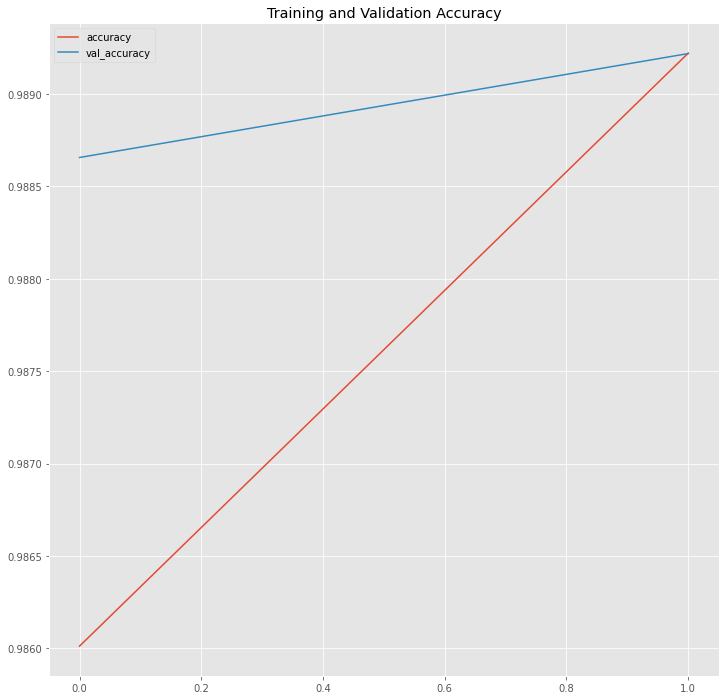

In [54]:
plt.figure(figsize=(12,12))
plt.plot(hist["accuracy"], label="accuracy")
plt.plot(hist["val_accuracy"], label="val_accuracy")
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [55]:
i = 5

p = model.predict(np.array([X_train[i]]))
p = np.argmax(p, axis=-1)

true_lbl = y_train[i]
true_lbl = np.argmax(true_lbl, axis=-1)

print("{:15} {:20}: {}".format("Word", "True", "Pred"))

for w, t, pred in zip(X_train[i], true_lbl, p[0]):    
    print("{:15}: {:20}: {}" .format(index2word[w], tags[t], tags[pred]))

Word            True                : Pred
Despite        : O                   : O
wide           : O                   : O
population     : O                   : O
-              : O                   : O
level          : O                   : O
isotopic       : O                   : O
niche          : O                   : O
breadths       : O                   : O
in             : O                   : O
both           : O                   : O
species        : O                   : O
,              : O                   : O
isotopic       : O                   : O
values         : O                   : O
of             : O                   : O
individual     : O                   : O
tiger          : B                   : O
sharks         : I                   : O
varied         : O                   : O
across         : O                   : O
tissues        : O                   : O
with           : O                   : O
different      : O                   : O
turnover      

##Evaluation

In [56]:
model.evaluate(x=X_test, y=y_test, batch_size=32, verbose=1)

1630/1630 [==============================] - 5s 3ms/step


[0.04260001992749656, 0.9884161353111267]

In [57]:
test_pred = model.predict(X_test, verbose=1)

1630/1630 [==============================] - 5s 3ms/step


In [58]:
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("ENDPAD", "O"))
        out.append(out_i)
    return out

def test2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            out_i.append(idx2tag[p].replace("ENDPAD", "O"))
        out.append(out_i)
    return out

In [59]:
def toLabel(pred):
    out = []
    for pred_i in pred:        
        out.append(np.asarray([idx2tag[np.argmax(i)] for i in  pred_i]))
    return np.asarray(out)


In [60]:
pred_labels = pred2label(test_pred)
test_labels = test2label(np.argmax(y_test, -1))

In [61]:
print(pred_labels[0])

['O', 'O', 'B', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [62]:
print(test_labels[0])

['B', 'I', 'I', 'I', 'I', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


###Tailored Evaluation


In [65]:
cd "/content/drive/My Drive/Colab Notebooks/BERT-QEMP/"

/content/drive/My Drive/Colab Notebooks/BERT-QEMP


In [66]:
from classification_metrics import classification_report, replaceMultiple

In [67]:
test_labels = [val for sublist in test_labels for val in sublist]
pred_labels = [val for sublist in pred_labels for val in sublist]

In [68]:
print(classification_report(test_labels, pred_labels))

                        precision 	 recall 	 f1-score 	 support

I                   	 0.67		 0.03		 0.05		 1048	
B                   	 0.46		 0.18		 0.26		 767	


macro avg           	 0.57		 0.10		 0.18		 1815	
micro avg           	 0.49		 0.09		 0.16		 1815	

